In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Set Seaborn style and ignore warnings
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


In [39]:
# Load dataset
df = pd.read_csv('googleplaystore.csv')

# Preview the first few rows
df.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [40]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values in 'Rating' with the median
df['Rating'].fillna(df['Rating'].median(), inplace=True)

# Drop rows with missing values in important columns
df.dropna(subset=['Reviews', 'Size', 'Installs'], inplace=True)


App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


In [41]:
# Convert 'Reviews' to integer after handling 'M' (millions) or 'K' (thousands)
def convert_reviews(reviews):
    reviews = str(reviews)  # Ensure it's a string before applying replace
    if 'M' in reviews:
        return float(reviews.replace('M', '')) * 1_000_000
    elif 'K' in reviews:
        return float(reviews.replace('K', '')) * 1_000
    else:
        return float(reviews)

df['Reviews'] = df['Reviews'].apply(convert_reviews).astype(int)


In [42]:
# Convert 'Installs' by ensuring the column is string first, then removing '+' and ','
df['Installs'] = df['Installs'].astype(str).apply(lambda x: x.replace(',', '').replace('+', ''))

# Replace 'Free' or other non-numeric values with NaN
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Convert 'Price' by ensuring it's a string, removing '$', and replacing non-numeric values with NaN
df['Price'] = df['Price'].astype(str).apply(lambda x: x.replace('$', '') if '$' in x else x)

# Replace non-numeric values like 'Everyone' with NaN
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Convert 'Size' to numeric (MB) by ensuring it's a string first
def convert_size(size):
    size = str(size)  # Ensure it's a string before applying replace
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1000
    else:
        return np.nan

df['Size'] = df['Size'].apply(convert_size)


In [43]:
# Check for duplicates and remove them
df.drop_duplicates(inplace=True)


In [44]:
# Create a connection to SQLite database (it creates a new one if it doesn't exist)
conn = sqlite3.connect('google_playstore.db')

# Load the cleaned dataframe into the database
df.to_sql('google_playstore', conn, if_exists='replace', index=False)

# Preview the first few rows from the SQL database
query = "SELECT * FROM google_playstore LIMIT 5;"
pd.read_sql(query, conn)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


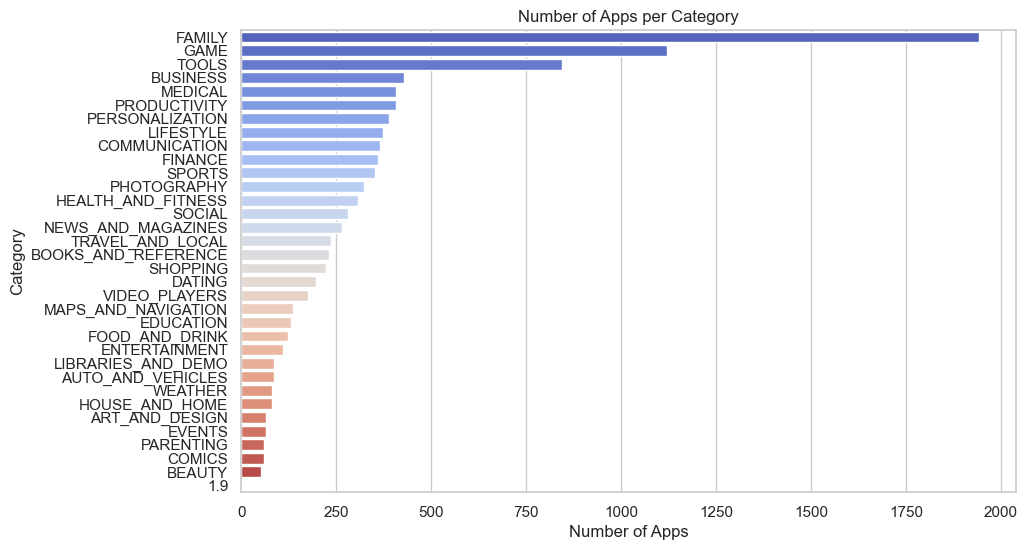

In [45]:
query = """
SELECT Category, COUNT(App) AS num_apps
FROM google_playstore
GROUP BY Category
ORDER BY num_apps DESC;
"""
category_count = pd.read_sql(query, conn)

# Plot the result
plt.figure(figsize=(10,6))
sns.barplot(x=category_count['num_apps'], y=category_count['Category'], palette='coolwarm')
plt.title('Number of Apps per Category')
plt.xlabel('Number of Apps')
plt.ylabel('Category')
plt.show()


In [46]:
query = """
SELECT Category, AVG(Rating) AS avg_rating
FROM google_playstore
GROUP BY Category
ORDER BY avg_rating DESC;
"""
avg_rating_per_category = pd.read_sql(query, conn)

# Display the result
avg_rating_per_category


,Category,avg_rating
0,1.9,19.000000
1,EVENTS,4.395313
2,EDUCATION,4.375385
3,ART_AND_DESIGN,4.355385
4,BOOKS_AND_REFERENCE,4.336522
5,PERSONALIZATION,4.327062
6,PARENTING,4.300000
7,BEAUTY,4.283019
8,GAME,4.282070
9,HEALTH_AND_FITNESS,4.266993


In [47]:
query = """
SELECT App, Price, Rating
FROM google_playstore
WHERE Type = 'Paid'
ORDER BY Price DESC
LIMIT 10;
"""
expensive_apps = pd.read_sql(query, conn)

# Display the result
expensive_apps


,App,Price,Rating
0,I'm Rich - Trump Edition,400.00,3.6
1,most expensive app (H),399.99,4.3
2,💎 I'm rich,399.99,3.8
3,I am rich,399.99,3.8
4,I am Rich Plus,399.99,4.0
5,I Am Rich Premium,399.99,4.1
6,I am Rich!,399.99,3.8
7,I am rich(premium),399.99,3.5
8,I Am Rich Pro,399.99,4.4
9,I am rich (Most expensive app),399.99,4.1


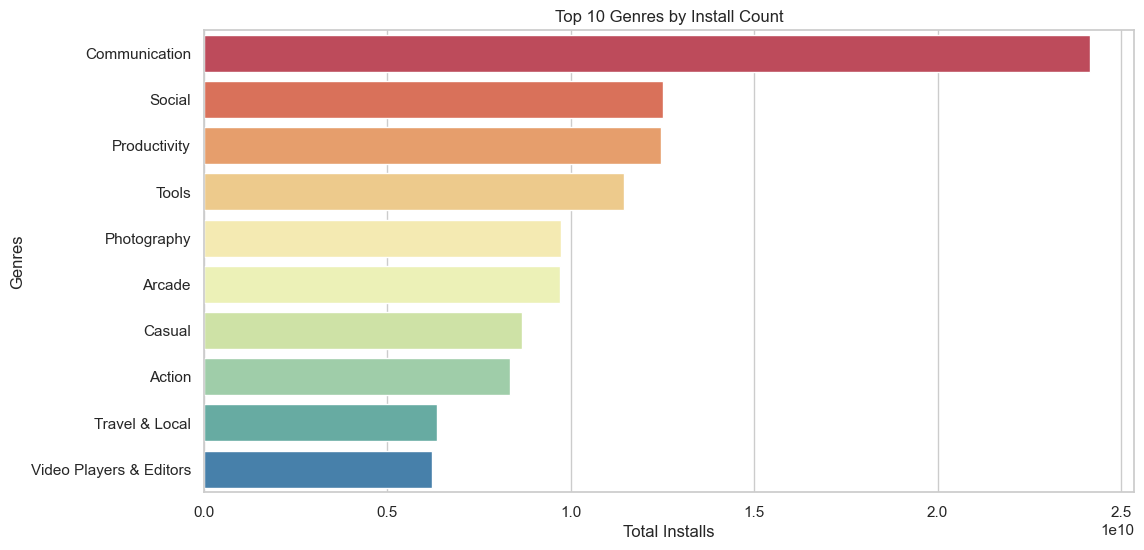

In [48]:
query = """
SELECT Genres, SUM(Installs) AS total_installs
FROM google_playstore
GROUP BY Genres
ORDER BY total_installs DESC
LIMIT 10;
"""
top_genres_installs = pd.read_sql(query, conn)

# Plot the result
plt.figure(figsize=(12,6))
sns.barplot(x=top_genres_installs['total_installs'], y=top_genres_installs['Genres'], palette='Spectral')
plt.title('Top 10 Genres by Install Count')
plt.xlabel('Total Installs')
plt.ylabel('Genres')
plt.show()


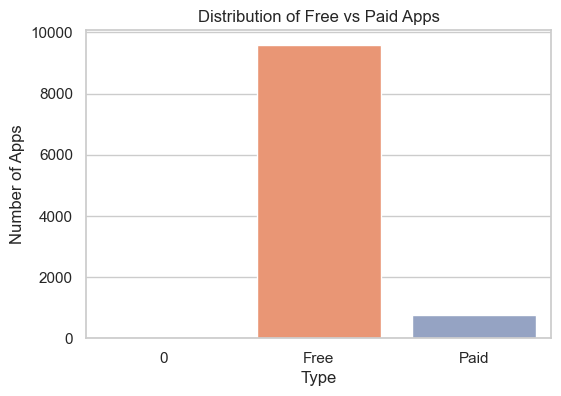

In [49]:
query = """
SELECT Type, COUNT(App) AS num_apps
FROM google_playstore
GROUP BY Type;
"""
free_vs_paid = pd.read_sql(query, conn)

# Plot the result
plt.figure(figsize=(6,4))
sns.barplot(x=free_vs_paid['Type'], y=free_vs_paid['num_apps'], palette='Set2')
plt.title('Distribution of Free vs Paid Apps')
plt.xlabel('Type')
plt.ylabel('Number of Apps')
plt.show()


In [50]:
# Load Reviews and Ratings from SQLite into a Pandas DataFrame
query = """
SELECT Reviews, Rating
FROM google_playstore
WHERE Reviews IS NOT NULL AND Rating IS NOT NULL;
"""
reviews_ratings = pd.read_sql(query, conn)

# Calculate the correlation between Reviews and Ratings
correlation = reviews_ratings['Reviews'].corr(reviews_ratings['Rating'])
print(f"Correlation between Reviews and Ratings: {correlation:.2f}")


Correlation between Reviews and Ratings: 0.06


In [51]:
label_encoder = LabelEncoder()

# Encode categorical columns
df['Category'] = label_encoder.fit_transform(df['Category'])
df['Type'] = label_encoder.fit_transform(df['Type'])
df['Content Rating'] = label_encoder.fit_transform(df['Content Rating'])
df['Genres'] = label_encoder.fit_transform(df['Genres'])


In [52]:
# Define features and target variable
X = df[['Category', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Genres', 'Content Rating']]
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [53]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


In [54]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')


Mean Squared Error: 0.22
R-squared: 0.08


In [55]:
print("Data analysis and model training completed.")


Data analysis and model training completed.


In [56]:
# Close the database connection
conn.close()
